In [253]:
import requests
import pandas as pd
import numpy as np
import datetime as dt

from datetime import date

# For Visualization
import matplotlib.pyplot as plt 
import chart_studio.plotly as py
import plotly.graph_objs as go

from mpl_toolkits.mplot3d import Axes3D
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib import pyplot

%matplotlib inline

# Error fix
import warnings
warnings.simplefilter("ignore")

plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False)

# Modeling
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [254]:
df = pd.read_csv('./Data/ec2_cpu_utilization_5f5533.csv')
df.head()

,timestamp,value
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714


In [255]:
print(df['timestamp'].min())
print(df['timestamp'].max())
print(len(df['timestamp']))

2014-02-14 14:27:00
2014-02-28 14:22:00
4032


In [256]:
init_notebook_mode(connected=True)
fig = go.Figure(data=[go.Scatter(x=df['timestamp'], y=df['value'])])
iplot(fig)

In [257]:
df_1=df.loc[(df['timestamp']>'2014-02-24 00:00:00') & (df['timestamp']<'2014-02-24 23:59:59')]
plt_dt = go.Scatter(x=df_1['timestamp'], y=df_1['value'])
fig=go.Figure(data=[plt_dt])
iplot(fig)

In [258]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import IsolationForest

#to_model_column='value'
clf=IsolationForest(n_estimators=10, max_samples='auto', contamination=float(.04), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(df_1[['value']])
df_1['scores']=clf.decision_function(df_1[['value']])
df_1['anomaly']=clf.predict(df_1[['value']])
df_1.loc[df_1['anomaly'] == 1,'anomaly'] = 0
df_1.loc[df_1['anomaly'] == -1,'anomaly'] = 1
df_1['anomaly'].value_counts()

0    276
1     12
Name: anomaly, dtype: int64

In [259]:
def plot_anomaly(df,metric_name):
    df.timestamp = pd.to_datetime(df['timestamp'].astype(str), format="%Y-%m-%d %H:%M:%S")
    dates = df.timestamp
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["value"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "white", 1: "plum"}

    table = go.Table(
        domain=dict(x=[0, 1],
                    y=[0, 0.5]),
        columnwidth=[1, 1],
        header=dict(height=27,
                    values=[['<b>날짜</b>'], ['<b>일별 거래량</b>'],],
                    font=dict(color='black', size=10),
                    fill=dict(color='darkgray')),
        cells=dict(values=[df.round(3)[k].tolist() for k in ['timestamp', 'value']],
                   line=dict(color='white'),
                   align=['center'],
                   font=dict(size=12),
                   suffix=[None] + [''] + [''] + ['%'] + [''],
                   height=27,
                   fill=dict(color=[df['anomaly'].map(color_map)])))
    
    Actuals = go.Scatter(name='Actuals',
                         x=dates,
                         y=df['value'],
                         xaxis='x1', 
                         yaxis='y1',
                         mode='lines',
                         marker=dict(size=12,
                                     line=dict(width=1),
                                     color="blue"))
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="darkmagenta",
                                           size=7,
                                           line=dict(
                                               color="darkmagenta",
                                               width=2)))
    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='white',
        tickfont=dict(size=10))
    layout = dict(
        width=1000,
        height=500,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    iplot(fig)
    pyplot.show()
plot_anomaly(df_1,'anomalies')

<AxesSubplot:>

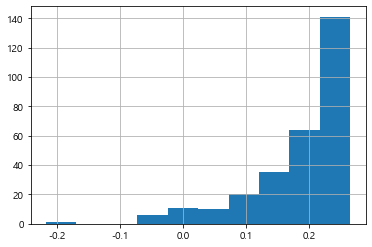

In [260]:
df_1['scores'].hist()